In [1]:
from diffusers import AutoPipelineForText2Image, DDIMScheduler, LCMScheduler, UNet2DConditionModel, FluxPipeline
import numpy as np
import torch
from diffusers.utils import load_image
import matplotlib.pyplot as plt

from transformers import CLIPVisionModelWithProjection

%load_ext autoreload
%autoreload 2


## IP Adapter

In [2]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=["ip-adapter-plus_sdxl_vit-h.safetensors"]
)
pipeline.set_ip_adapter_scale(1)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
image = load_image("/home/dcor/orlichter/concept_collage/dancing_banana.jpeg")
image

In [5]:
generator = torch.Generator(device="cpu").manual_seed(0)
pipeline.set_ip_adapter_scale(0)
images = pipeline(
    prompt="a 3d render of a cute humanoid banana wearing a tutu dancing, white background",
    ip_adapter_image=[image],
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=50,
    generator=generator,
    num_images_per_prompt=1,
).images

True


  0%|          | 0/50 [00:00<?, ?it/s]

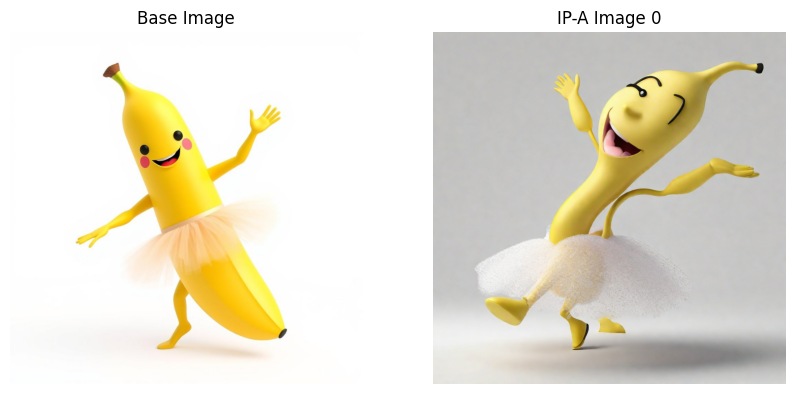

In [6]:
fig, axes = plt.subplots(1, len(images) + 1, figsize=(10, 10))

# Display the images
axes[0].imshow(image)
axes[0].axis('off')  # Hide axes for a cleaner look
axes[0].set_title("Base Image")

for i, generated_image in enumerate(images):
    axes[i+1].imshow(generated_image)
    axes[i+1].axis('off')  # Hide axes for a cleaner look
    axes[i+1].set_title(f"IP-A Image {i}")

# Display the plot
plt.show()


## IP Adapter + LCM

In [7]:
unet = UNet2DConditionModel.from_pretrained(
    "latent-consistency/lcm-sdxl",
    torch_dtype=torch.float16,
    variant="fp16",
)

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
    unet=unet,
)

pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=["ip-adapter-plus_sdxl_vit-h.safetensors"]
)
pipeline.set_ip_adapter_scale(0.4)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [3]:
image = load_image("/home/dcor/orlichter/concept_collage/platypus_porcupine.jpeg")

In [16]:
generator = torch.Generator(device="cpu").manual_seed(0)
images = pipeline(
    prompt="a cartoon platypus with a sword fighting a porcupine",
    ip_adapter_image=[image],
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=3,
    guidance_scale=8.0,
    generator=generator,
    num_images_per_prompt=2,
).images

  0%|          | 0/3 [00:00<?, ?it/s]

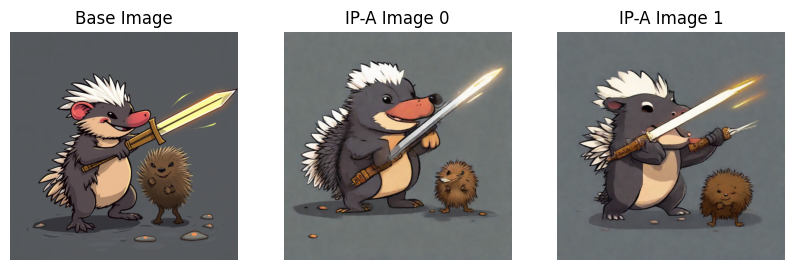

In [17]:
fig, axes = plt.subplots(1, len(images) + 1, figsize=(10, 10))

# Display the images
axes[0].imshow(image)
axes[0].axis('off')  # Hide axes for a cleaner look
axes[0].set_title("Base Image")

for i, generated_image in enumerate(images):
    axes[i+1].imshow(generated_image)
    axes[i+1].axis('off')  # Hide axes for a cleaner look
    axes[i+1].set_title(f"IP-A Image {i}")

# Display the plot
plt.show()


## IP Adapter + LCM-Lora

In [42]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
)
pipeline.load_lora_weights("latent-consistency/lcm-lora-sdxl")
pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=["ip-adapter-plus_sdxl_vit-h.safetensors"]
)
pipeline.set_ip_adapter_scale(1.)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [44]:
image = load_image("/home/dcor/orlichter/concept_collage/dancing_banana.jpeg")

In [43]:
generator = torch.Generator(device="cpu").manual_seed(0)
images = pipeline(
    prompt="a 3d render of a cute humanoid banana wearing a tutu dancing, white background",
    ip_adapter_image=[image],
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=4,
    guidance_scale=0.0,
    generator=generator,
    num_images_per_prompt=2,
).images

False


  0%|          | 0/4 [00:00<?, ?it/s]

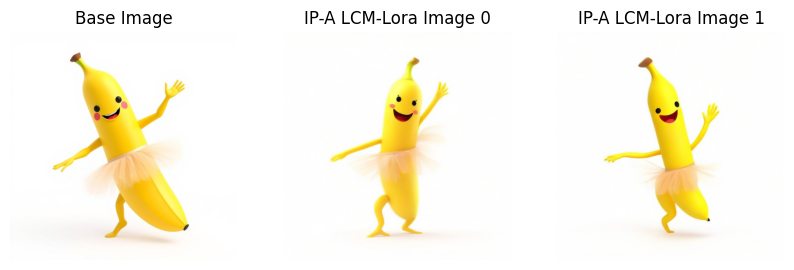

In [45]:
fig, axes = plt.subplots(1, len(images) + 1, figsize=(10, 10))

# Display the images
axes[0].imshow(image)
axes[0].axis('off')  # Hide axes for a cleaner look
axes[0].set_title("Base Image")

for i, generated_image in enumerate(images):
    axes[i+1].imshow(generated_image)
    axes[i+1].axis('off')  # Hide axes for a cleaner look
    axes[i+1].set_title(f"IP-A LCM-Lora Image {i}")

# Display the plot
plt.show()



## IP Adapter + SDXL Turbo

In [3]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=["ip-adapter-plus_sdxl_vit-h.safetensors"]
)
pipeline.set_ip_adapter_scale(1)
pipeline.enable_model_cpu_offload()

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
image = load_image("/home/dcor/orlichter/concept_collage/humanoid_flower.jpeg")

In [21]:
generator = torch.Generator(device="cpu").manual_seed(0)
images = pipeline(
    prompt="a 3d render of a cute humanoid flower holding a sword and wearing a red hat, white background",
    ip_adapter_image=[image],
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=4,
    guidance_scale=0.0,
    generator=generator,
    num_images_per_prompt=2,
).images

False


  0%|          | 0/4 [00:00<?, ?it/s]

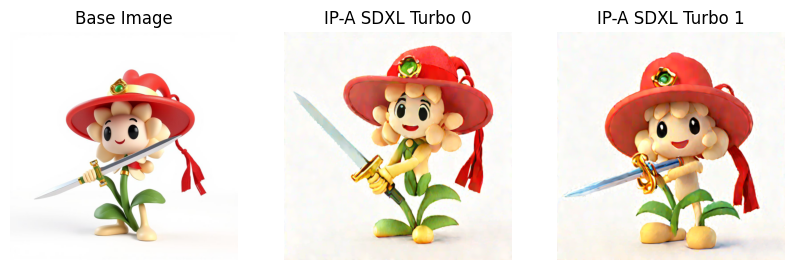

In [22]:
fig, axes = plt.subplots(1, len(images) + 1, figsize=(10, 10))

# Display the images
axes[0].imshow(image)
axes[0].axis('off')  # Hide axes for a cleaner look
axes[0].set_title("Base Image")

for i, generated_image in enumerate(images):
    axes[i+1].imshow(generated_image)
    axes[i+1].axis('off')  # Hide axes for a cleaner look
    axes[i+1].set_title(f"IP-A SDXL Turbo {i}")

# Display the plot
plt.show()



## Base

In [9]:
generation_pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
)
generation_pipeline.scheduler = LCMScheduler.from_config(generation_pipeline.scheduler.config)
generation_pipeline.load_lora_weights("latent-consistency/lcm-lora-sdxl")
generation_pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

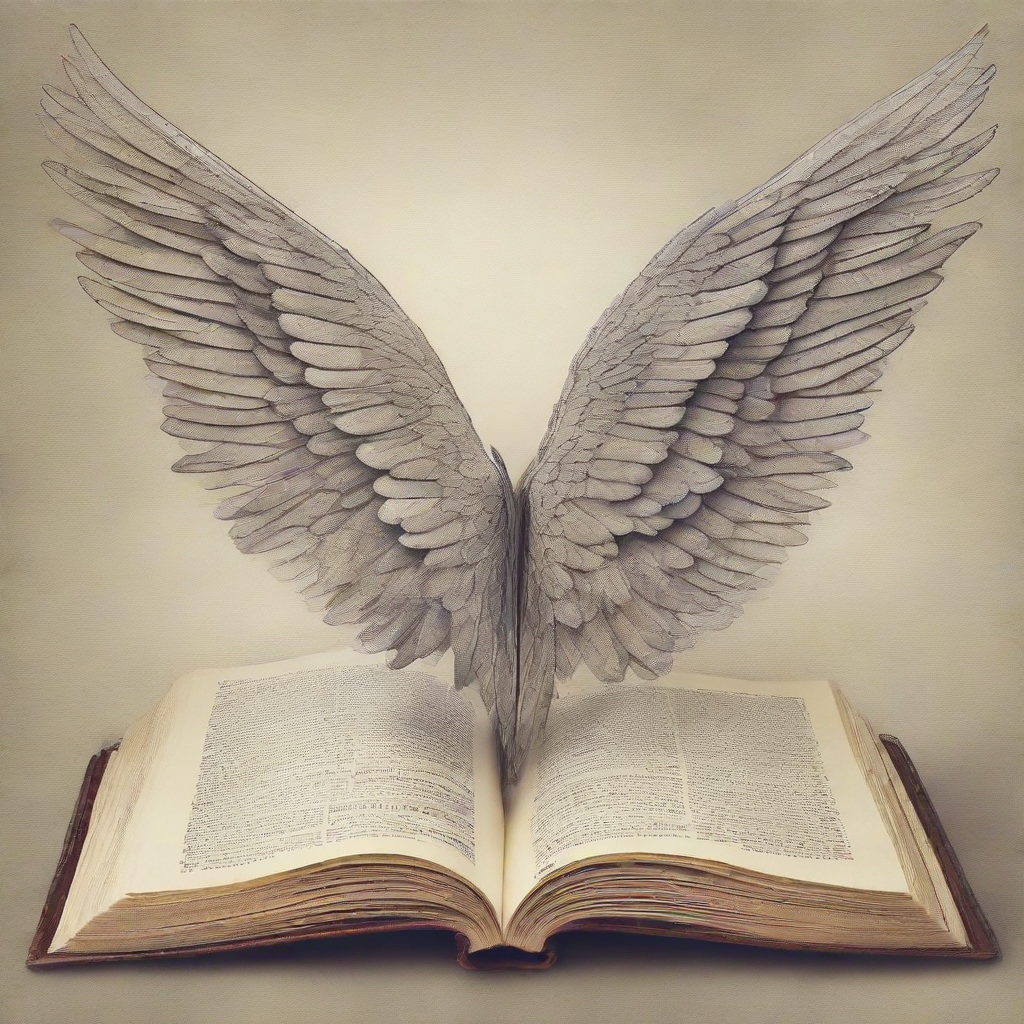

In [13]:
generation_pipeline(
            prompt="a book with wings",
            negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
            num_inference_steps=4,  # Always use 4 steps for LCM-LORA
            num_images_per_prompt=1,
            guidance_scale=0.0,
        ).images[0]

## Flux Schnell

In [4]:
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

image = pipe(
    "a 3d render of a cute humanoid banana wearing a tutu dancing, white background",
    guidance_scale=0.0,
    num_inference_steps=4,
    max_sequence_length=256,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 1 has a total capacty of 10.91 GiB of which 18.12 MiB is free. Including non-PyTorch memory, this process has 10.89 GiB memory in use. Of the allocated memory 10.30 GiB is allocated by PyTorch, and 10.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF